<a href="https://colab.research.google.com/github/Takudzwamz/comp_v_lab_4/blob/main/Transfer_learning_Cars_Bikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transfer Learning Image classification

In [7]:
import os
import zipfile
import shutil
from random import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Path to the ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/comp_vision/lab4/Car-Bike-Dataset.zip'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

# Base directory after unzipping
base_dir = '/content/Car-Bike-Dataset'

# Directories for our training, validation, and test splits
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create directories for training, validation, and test sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)



# Check if the data has already been split
if not os.listdir(train_dir) and not os.listdir(validation_dir) and not os.listdir(test_dir):
    # Perform data splitting
    def split_data(source, train, validation, test, split_sizes):
      files = os.listdir(source)
      shuffle(files)
      split_index_train = int(len(files) * split_sizes[0])
      split_index_validation = split_index_train + int(len(files) * split_sizes[1])

      train_files = files[:split_index_train]
      validation_files = files[split_index_train:split_index_validation]
      test_files = files[split_index_validation:]

      for file in train_files:
          src_file = os.path.join(source, file)
          dst_file = os.path.join(train, file)
          if not os.path.exists(dst_file):
              shutil.move(src_file, dst_file)

      for file in validation_files:
          src_file = os.path.join(source, file)
          dst_file = os.path.join(validation, file)
          if not os.path.exists(dst_file):
              shutil.move(src_file, dst_file)

      for file in test_files:
          src_file = os.path.join(source, file)
          dst_file = os.path.join(test, file)
          if not os.path.exists(dst_file):
              shutil.move(src_file, dst_file)

    # Define split sizes (70% for training, 20% for validation, 10% for testing)
    split_sizes = (0.7, 0.2, 0.1)

    # Create subdirectories for each class in train, validation, and test directories
    for category in ['Bike', 'Car']:
        category_train_dir = os.path.join(train_dir, category)
        category_validation_dir = os.path.join(validation_dir, category)
        category_test_dir = os.path.join(test_dir, category)

        os.makedirs(category_train_dir, exist_ok=True)
        os.makedirs(category_validation_dir, exist_ok=True)
        os.makedirs(category_test_dir, exist_ok=True)

        split_data(os.path.join(base_dir, category),
                  category_train_dir,
                  category_validation_dir,
                  category_test_dir,
                  split_sizes)
else:
    print("Data already split. Skipping data splitting.")


# Preprocess the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# Preprocess test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

# Load the pre-trained MobileNetV2 model
"""
Pre-Trained Model: The code uses MobileNetV2, a model pre-trained on the ImageNet dataset, as the base model.
This model has already learned rich feature representations for a wide range of images.

"""
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



# Freeze the base model
"""
Freezing the Base Model: The weights of the pre-trained MobileNetV2 model are frozen.
This means that these weights will not be updated during training.
Our training will only update the weights of the new layers you add.
"""
base_model.trainable = False

# Add custom layers for our specific task
"""
Adding Custom Layers: We add new layers (a global average pooling layer and two dense layers) on top of the base model.
These layers are tailored to our specific task (binary classification between Cars and Bikes).

"""
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=5)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")

# Save the model
model.save('car_bike_classifier.keras')


Data already split. Skipping data splitting.
Found 2801 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/10
10/10 [==============================] - 9s 462ms/step - loss: 0.5143 - accuracy: 0.7600 - val_loss: 0.2072 - val_accuracy: 0.9700
Epoch 2/10
10/10 [==============================] - 3s 277ms/step - loss: 0.1767 - accuracy: 0.9600 - val_loss: 0.0847 - val_accuracy: 0.9900
Epoch 3/10
10/10 [==============================] - 3s 338ms/step - loss: 0.1389 - accuracy: 0.9550 - val_loss: 0.0652 - val_accuracy: 0.9900
Epoch 4/10
10/10 [==============================] - 4s 403ms/step - loss: 0.0971 - accuracy: 0.9550 - val_loss: 0.0478 - val_accuracy: 0.9800
Epoch 5/10
10/10 [==============================] - 3s 273ms/step - loss: 0.1048 - accuracy: 0.9750 - val_loss: 0.0670 - val_accuracy: 0.9800
Epoch 6/10
10/10 [==============================] - 3s 270ms/step - loss: 0.1074 - accuracy: 0.9550 - val_loss: 0.0232 - 

# Visualizing test results

1/1 [==============================] - 0s 20ms/step


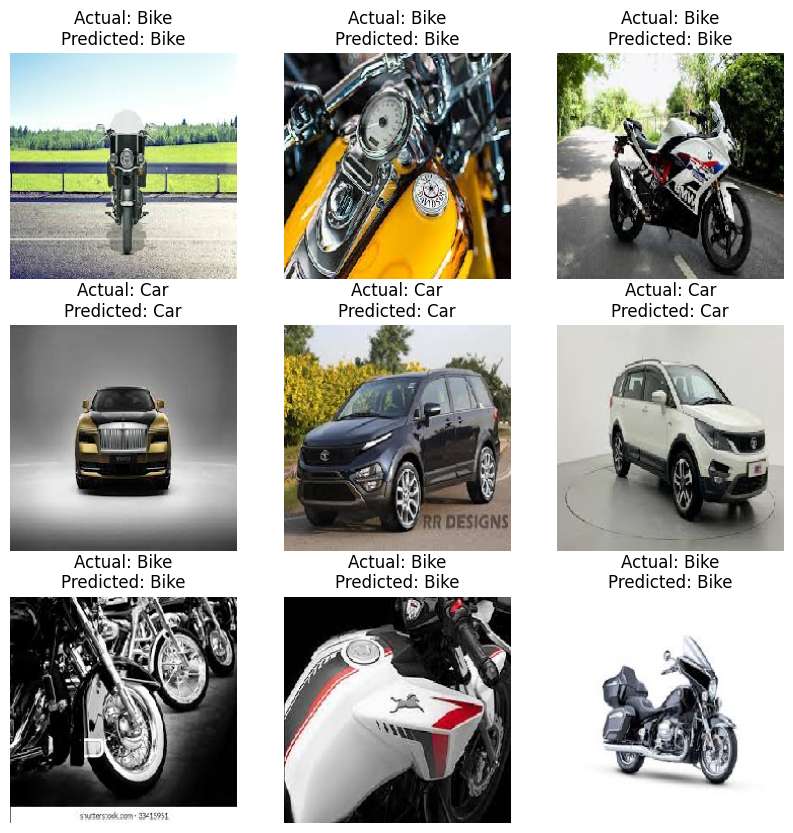

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_predictions(images, labels, predictions):
    """Plots images with their labels and model predictions."""
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        # Rescale image for display
        display_image = (images[i] * 255).astype(np.uint8)
        plt.imshow(display_image)
        plt.title(f"Actual: {labels[i]}\nPredicted: {predictions[i]}")
        plt.axis("off")

# Load a few images from  test set
test_images = []  # List to store images
test_labels = []  # List to store actual labels
predictions = []  # List to store model predictions
for _ in range(9):  # Adjust range for number of images to display
    batch = next(test_generator)
    for i in range(batch[0].shape[0]):
        img = batch[0][i]
        label = batch[1][i]

        # Predict
        pred = model.predict(np.expand_dims(img, axis=0))
        pred_label = "Car" if pred[0][0] > 0.5 else "Bike"

        # Store data for plotting
        test_images.append(img)
        test_labels.append("Car" if label == 1 else "Bike")
        predictions.append(pred_label)

        if len(test_images) >= 9:
            break
    if len(test_images) >= 9:
        break

# Plot the images with predictions
plot_images_with_predictions(test_images, test_labels, predictions)


# Some interesting plots

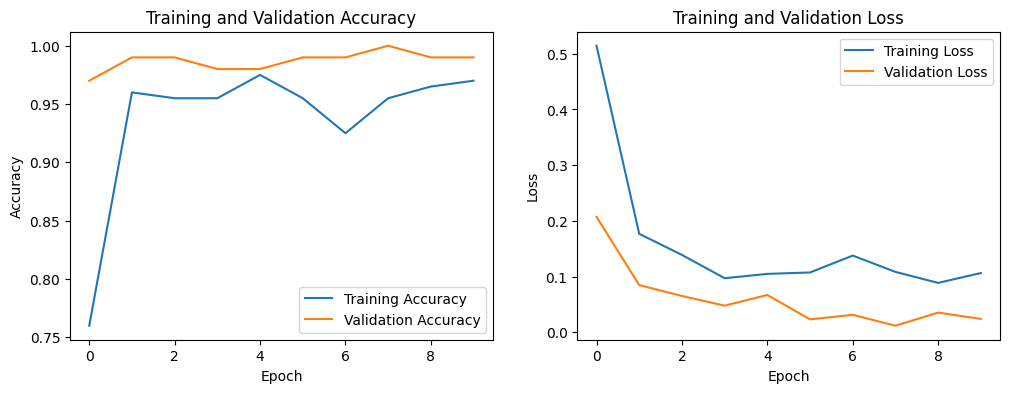

In [11]:
import matplotlib.pyplot as plt

# Assuming 'history' is the return value of the 'fit' method on your model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # Number of epochs

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
